In [1]:
import os
import sys
import glob
import datetime
import platform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

from tqdm import tqdm
from scipy import signal

def flatter(data, polynomialOrder=15):

    ## Применяем медианную фильтрацию с максимальным шагом:
    res_filter = signal.medfilt(data, kernel_size=29)
    # Фитируем получившийся массив:
    xData = range(len(res_filter))
    yData = res_filter
    # curve fit the data
    fittedParameters = np.polyfit(xData, yData, polynomialOrder)
    xModel = np.linspace(min(xData), max(xData), len(xData))
    yModel = np.polyval(fittedParameters, xModel)

    return yModel

if 'Windows' in platform.platform() and '8.1' in platform.release():
    _ = "C:\\Users\\Andrey\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    DELIMITER = "\\"

elif 'Windows' in platform.platform() and '7' in platform.release():
    _ = "E:\\Disk.Yandex\\3.Programing\\"
    DATA_DIR = "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    DELIMITER = "\\"

elif 'Windows' in platform.platform() and '10' in platform.release():
    _ = "F:\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "F:\\YandexDisk\\1.Работа\\Результаты обработки\\"
    DELIMITER = "\\"

elif 'Linux' in platform.platform() and '4.4.0' in platform.release():
    _ = "/home/andr/Yandex.Disk/3.Programing/"
    DATA_DIR = _ + "work/PulseViewer/pulsarsData/"
    PATTERN_DIR = _ + "/work/PulseViewer/frame_of_AP/patterns/"
    PACK_DIR = _ + "myPacks/"
    ALL_DATA = "/home/andr/Yandex.Disk/1.Работа/Результаты обработки/"
    DELIMITER = "/"

else:
    print('unknown system', platform.platform(), platform.release())

sys.path.append(PACK_DIR)
from PRAO import *

# Создание списка дат хороших дней
list_files = sorted(glob.glob('./good_days_full/*'))
date_good_list = [os.path.basename(i)[:10] for i in list_files]

In [2]:
files_0531 = glob.glob(ALL_DATA + '0531+21'
                       + DELIMITER + '*' + DELIMITER + '*' + DELIMITER
                       + '*_profiles.txt')
print('Main object: 0531+21; Numbers of files: ' + str(len(files_0531)))

# установка диапазона дат
date_start = datetime.datetime(2009, 11, 20, 0, 0)
data_stop = datetime.datetime(2019, 11, 18, 0, 0)

main_set = [x for x in files_0531
             if date_start <= datetime.datetime.strptime(os.path.basename(x)[:6], '%d%m%y') <= data_stop]
print('Main set: 0531+21; Numbers of files: ' + str(len(main_set)))

Main object: 0531+21; Numbers of files: 3040
Main set: 0531+21; Numbers of files: 3040


In [3]:
amp_adcu = []
date_list = []
for file_name in tqdm(main_set):
    try:
        head, main_pulse, data_pulses, back = read_profiles_MD(file_name)
        day, month, year = head['date'].split('.')
        if head['date'] in date_good_list:

            non_cor_data = []
            for pulse, backg in zip(data_pulses, back):
                non_cor_data.append(pulse + backg)
            obser = np.hstack(non_cor_data)

            poli = flatter(obser, 4)
            max_calib = max(poli[35000:45000])
            min_calib = min(poli)
            amp_adcu.append(max_calib - min_calib)
            date_list.append(f'{year}.{month}.{day}')

    except ValueError:
        with open('valerr_' + 'crab' + '.log', 'a') as f:
            f.write(os.path.basename(file_name))
            f.write('\n')
    except OSError:
        with open('oserr_' + 'crab' + '.log', 'a') as f:
            f.write(os.path.basename(file_name))
            f.write('\n')

100%|██████████████████████████████████████████████████████████████████████████████| 3040/3040 [18:11<00:00,  2.78it/s]


In [4]:
print(len(amp_adcu), len(date_list))

2102 2102


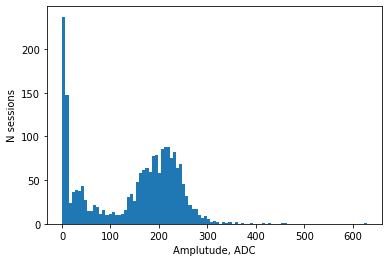

In [5]:
bins = np.linspace(np.min(amp_adcu), np.max(amp_adcu), 100)
plt.close()
plt.ylabel('N sessions')
plt.xlabel('Amplutude, ADC')
plt.hist(amp_adcu, bins=bins)
plt.savefig('amplitude_max_min.png', format='png', dpi=300)

In [17]:
date_list_dt = [datetime.datetime.strptime(i, "%Y.%m.%d") for i in date_list]

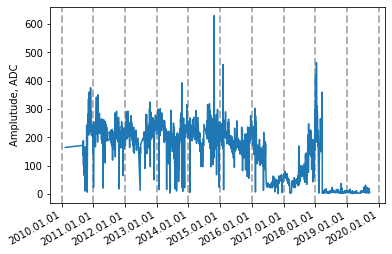

In [40]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
plt.close()
fig, ax = plt.subplots()
ax.plot(date_list_dt, amp_adcu)
myFmt = mdates.DateFormatter("%Y.%m.%d")
ax.xaxis.set_major_formatter(myFmt)
plt.grid(which='major', axis='x', linestyle='--', lw=2)
plt.ylabel('Amplutude, ADC')
fig.autofmt_xdate()
plt.savefig('amplitude_max_min_by-session.png', format='png', dpi=300)

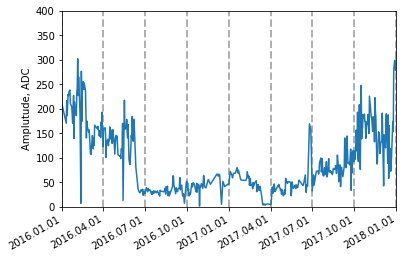

In [41]:
d_start = datetime.datetime.strptime('2016.01.01', "%Y.%m.%d")
d_stop = datetime.datetime.strptime('2018.01.01', "%Y.%m.%d")
fig, ax = plt.subplots()
ax.plot(date_list_dt, amp_adcu)
myFmt = mdates.DateFormatter("%Y.%m.%d")
ax.xaxis.set_major_formatter(myFmt)
plt.grid(which='major', axis='x', linestyle='--', lw=2)
plt.ylabel('Amplutude, ADC')
ax.set_xlim(d_start, d_stop)
ax.set_ylim(0, 400)
fig.autofmt_xdate()
plt.savefig('amplitude_max_min_by-session-16-18.png', format='png', dpi=300)

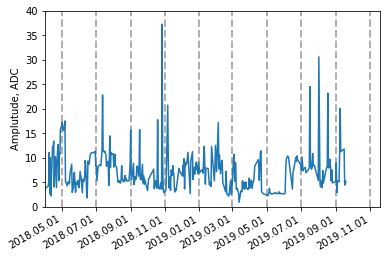

In [42]:
d_start = datetime.datetime.strptime('2018.04.01', "%Y.%m.%d")
d_stop = datetime.datetime.strptime('2019.11.18', "%Y.%m.%d")
fig, ax = plt.subplots()
ax.plot(date_list_dt, amp_adcu)
myFmt = mdates.DateFormatter("%Y.%m.%d")
ax.xaxis.set_major_formatter(myFmt)
plt.grid(which='major', axis='x', linestyle='--', lw=2)
plt.ylabel('Amplutude, ADC')
ax.set_xlim(d_start, d_stop)
ax.set_ylim(0, 40)
fig.autofmt_xdate()
plt.savefig('amplitude_max_min_by-session-18-19.png', format='png', dpi=300)